**data preparation**

In [ ]:
!pip install datasets
import kagglehub
import os
import bz2
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

# Download the dataset
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
dataset_path = "/root/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7"
print("Files in the dataset:")
print(os.listdir(dataset_path))

# Paths to the train and test files
train_file = f"{dataset_path}/train.ft.txt.bz2"
test_file = f"{dataset_path}/test.ft.txt.bz2"

# Read the first few lines of the training file
with bz2.open(train_file, "rt", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i >= 5:
            break

# Function to load bz2 file into a pandas DataFrame
def load_bz2_file(file_path, num_lines=None):
    data = []
    with bz2.open(file_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if num_lines and i >= num_lines:
                break
            label, text = line.split(' ', 1)
            data.append({'label': label.strip(), 'text': text.strip()})
    return pd.DataFrame(data)

# Load a sample of the training data
train_data = load_bz2_file(train_file, num_lines=1000)
print(train_data.head())

# Preprocess label column to convert
train_data['label'] = train_data['label'].str.replace('__label__', '').astype(int) - 1

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(train_data)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Tokenize
tokenized_dataset = dataset.map(tokenize_function, batched=True)
print(tokenized_dataset)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


100%|██████████| 493M/493M [00:03<00:00, 132MB/s]

Extracting files...


Files in the dataset:
['train.ft.txt.bz2', 'test.ft.txt.bz2']
__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would b

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


**first run of optuna**

In [ ]:
# Install necessary libraries
!pip install transformers accelerate peft datasets optuna torch torchtune torchao
!pip install torch==2.0.1+cu118 transformers==4.34.0 -f https://download.pytorch.org/whl/cu118/torch_stable.html

# Kagglehub for downloading dataset
import os
import bz2
import pandas as pd
import optuna
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split

# Kaggle dataset download
import kagglehub

# Disable Weights and Biases (W&B)
os.environ["WANDB_DISABLED"] = "true"  # This will prevent W&B from being initialized

# Download the dataset
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Path to dataset files:", path)

# Check dataset files
dataset_path = "/root/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7"
print("Files in the dataset:", os.listdir(dataset_path))

# Training and testing file paths
train_file = os.path.join(dataset_path, "train.ft.txt.bz2")
test_file = os.path.join(dataset_path, "test.ft.txt.bz2")

# Function to load a bz2 file into a pandas DataFrame
def load_bz2_file(file_path, num_lines=None):
    data = []
    with bz2.open(file_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if num_lines and i >= num_lines:
                break
            label, text = line.split(' ', 1)
            data.append({'label': label.strip(), 'text': text.strip()})
    return pd.DataFrame(data)

# Load a sample of the training data
train_data = load_bz2_file(train_file, num_lines=10000)  # Load more data for better validation
print("Loaded training data sample:")
print(train_data.head())

# Preprocess labels to remove the "__label__" prefix and convert to integers
train_data['label'] = train_data['label'].str.replace('__label__', '').astype(int) - 1

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['text'], train_data['label'], test_size=0.2, random_state=42
)

# Create Hugging Face DatasetDict
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)
print("Tokenized dataset example:")
print(tokenized_datasets["train"][0])

# Define the function to train the model
def train_model(config, tokenized_datasets):
    """Trains and evaluates a model with given configuration."""
    # Load the BERT model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    # Configure LoRA
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=config["lora_r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=config["lora_dropout"],
        target_modules=["query", "value"],
    )
    model = get_peft_model(model, lora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",  # evaluate after each epoch
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        save_strategy="no",
        logging_dir=None,  # Disable logging
        logging_steps=10,
        disable_tqdm=True,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],  # Provide validation dataset
    )

    # Train the model
    trainer.train()

    # Return evaluation loss for optimization
    return trainer.evaluate()["eval_loss"]

# Define the objective function for Optuna optimization
def objective(trial):
    """Objective function for Optuna optimization."""
    config = {
        "lora_r": trial.suggest_categorical("lora_r", [8, 16, 32]),
        "lora_alpha": trial.suggest_categorical("lora_alpha", [16, 32]),
        "lora_dropout": trial.suggest_categorical("lora_dropout", [0.1, 0.2]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "epochs": trial.suggest_int("epochs", 3, 5),
    }
    return train_model(config, tokenized_datasets)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

# Applying the best hyperparameters
best_config = study.best_params
print("Training with the best configuration...")
final_loss = train_model(best_config, tokenized_datasets)
print("Final evaluation loss:", final_loss)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.9/686.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=ca77d2340d8e2c14ffe11eb148eb8d94f8f7d7db6b85947ff89c1676369de667
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Looking in links: https://download.pytorch.org/whl/cu118/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 919.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.3
    Uninstalling huggingface-hub-0.26.3:
      Successfully uninstalled huggingface-hub-0.26.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attemp

Path to dataset files: /root/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7
Files in the dataset: ['train.ft.txt.bz2', 'test.ft.txt.bz2']
Loaded training data sample:
        label                                               text
0  __label__2  Stuning even for the non-gamer: This sound tra...
1  __label__2  The best soundtrack ever to anything.: I'm rea...
2  __label__2  Amazing!: This soundtrack is my favorite music...
3  __label__2  Excellent Soundtrack: I truly like this soundt...
4  __label__2  Remember, Pull Your Jaw Off The Floor After He...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

[I 2024-12-08 00:14:17,366] A new study created in memory with name: no-name-6974c0c5-d9c7-48a5-b506-d58521fc41d6
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenized dataset example:
{'text': 'Nutritious and delicious: Though one reviewer felt the format of this book was a poor choice, I found it to be perfect. I can leave a spare copy with one of my grocery bags so that I can pick out a new recipe or two while at the grocery store. I find that this lets me find the freshest foods available.What I like most about this book is that with a little preperation and fore thought, you can do much of your cooking for meals in advance, and just combine ingredients and heat when meal time comes. This can be done because many of the recipes call for "cooked rice" or "cooked peas". I find that this also allows you to use leftovers up quickly, in new recipes.One note, though, is that this book is not Vegan by any means. Many of the recipes call for dairy products and eggs.Overall, it is a lovely lovely book and a must for those trying to live lightly on the earth.', 'label': 1, 'input_ids': [101, 17490, 14778, 6313, 1998, 12090, 1024, 2295, 2028, 1202

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7197, 'grad_norm': 5.638540267944336, 'learning_rate': 2.568223621847296e-05, 'epoch': 0.01}
{'loss': 0.7299, 'grad_norm': 1.9919953346252441, 'learning_rate': 2.563076881122151e-05, 'epoch': 0.02}
{'loss': 0.6958, 'grad_norm': 2.2128188610076904, 'learning_rate': 2.5579301403970064e-05, 'epoch': 0.03}
{'loss': 0.7189, 'grad_norm': 2.155109405517578, 'learning_rate': 2.5527833996718614e-05, 'epoch': 0.04}
{'loss': 0.713, 'grad_norm': 1.6840802431106567, 'learning_rate': 2.5476366589467164e-05, 'epoch': 0.05}
{'loss': 0.6854, 'grad_norm': 8.75184440612793, 'learning_rate': 2.5424899182215715e-05, 'epoch': 0.06}
{'loss': 0.7128, 'grad_norm': 12.6788911819458, 'learning_rate': 2.537343177496427e-05, 'epoch': 0.07}
{'loss': 0.6865, 'grad_norm': 8.526091575622559, 'learning_rate': 2.532196436771282e-05, 'epoch': 0.08}
{'loss': 0.6781, 'grad_norm': 5.754039287567139, 'learning_rate': 2.527049696046137e-05, 'epoch': 0.09}
{'loss': 0.6824, 'grad_norm': 6.0630035400390625, 'learning_

[I 2024-12-08 00:26:47,344] Trial 0 finished with value: 0.22964946925640106 and parameters: {'lora_r': 32, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 2.573370362572441e-05, 'batch_size': 8, 'epochs': 5}. Best is trial 0 with value: 0.22964946925640106.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.22964946925640106, 'eval_runtime': 15.1147, 'eval_samples_per_second': 132.321, 'eval_steps_per_second': 16.54, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7084, 'grad_norm': 3.8022513389587402, 'learning_rate': 2.689064845819711e-05, 'epoch': 0.02}
{'loss': 0.7053, 'grad_norm': 4.1554646492004395, 'learning_rate': 2.6782653886075835e-05, 'epoch': 0.04}
{'loss': 0.6817, 'grad_norm': 3.3433547019958496, 'learning_rate': 2.6674659313954563e-05, 'epoch': 0.06}
{'loss': 0.7003, 'grad_norm': 6.677840709686279, 'learning_rate': 2.6566664741833287e-05, 'epoch': 0.08}
{'loss': 0.6868, 'grad_norm': 3.221615791320801, 'learning_rate': 2.6458670169712015e-05, 'epoch': 0.1}
{'loss': 0.6946, 'grad_norm': 1.9487332105636597, 'learning_rate': 2.635067559759074e-05, 'epoch': 0.12}
{'loss': 0.6873, 'grad_norm': 3.4075067043304443, 'learning_rate': 2.6242681025469468e-05, 'epoch': 0.14}
{'loss': 0.691, 'grad_norm': 1.9706261157989502, 'learning_rate': 2.6134686453348192e-05, 'epoch': 0.16}
{'loss': 0.6898, 'grad_norm': 1.2271054983139038, 'learning_rate': 2.602669188122692e-05, 'epoch': 0.18}
{'loss': 0.6752, 'grad_norm': 3.439939260482788, 'lea

[I 2024-12-08 00:38:28,540] Trial 1 finished with value: 0.21144111454486847 and parameters: {'lora_r': 32, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 2.6998643030318383e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 1 with value: 0.21144111454486847.


{'eval_loss': 0.21144111454486847, 'eval_runtime': 15.0543, 'eval_samples_per_second': 132.852, 'eval_steps_per_second': 16.606, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7094, 'grad_norm': 4.067743301391602, 'learning_rate': 1.8232982728161723e-05, 'epoch': 0.02}
{'loss': 0.7091, 'grad_norm': 4.557974338531494, 'learning_rate': 1.815975789792814e-05, 'epoch': 0.04}
{'loss': 0.6839, 'grad_norm': 3.0541157722473145, 'learning_rate': 1.808653306769456e-05, 'epoch': 0.06}
{'loss': 0.7065, 'grad_norm': 7.234842300415039, 'learning_rate': 1.8013308237460978e-05, 'epoch': 0.08}
{'loss': 0.6933, 'grad_norm': 3.7535438537597656, 'learning_rate': 1.7940083407227398e-05, 'epoch': 0.1}
{'loss': 0.7002, 'grad_norm': 2.4802334308624268, 'learning_rate': 1.7866858576993814e-05, 'epoch': 0.12}
{'loss': 0.6934, 'grad_norm': 3.0718255043029785, 'learning_rate': 1.7793633746760234e-05, 'epoch': 0.14}
{'loss': 0.6992, 'grad_norm': 1.6798733472824097, 'learning_rate': 1.7720408916526653e-05, 'epoch': 0.16}
{'loss': 0.6973, 'grad_norm': 1.2575397491455078, 'learning_rate': 1.7647184086293073e-05, 'epoch': 0.18}
{'loss': 0.6847, 'grad_norm': 4.044486999511719, 'le

[I 2024-12-08 00:50:09,751] Trial 2 finished with value: 0.24828843772411346 and parameters: {'lora_r': 32, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 1.8306207558395303e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 1 with value: 0.21144111454486847.


{'eval_loss': 0.24828843772411346, 'eval_runtime': 15.0168, 'eval_samples_per_second': 133.184, 'eval_steps_per_second': 16.648, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7265, 'grad_norm': 1.837395429611206, 'learning_rate': 1.3760631145472274e-05, 'epoch': 0.01}
{'loss': 0.6873, 'grad_norm': 4.539834022521973, 'learning_rate': 1.371460896772822e-05, 'epoch': 0.02}
{'loss': 0.7141, 'grad_norm': 4.643189430236816, 'learning_rate': 1.3668586789984165e-05, 'epoch': 0.03}
{'loss': 0.6814, 'grad_norm': 4.940901279449463, 'learning_rate': 1.362256461224011e-05, 'epoch': 0.04}
{'loss': 0.6658, 'grad_norm': 2.0548508167266846, 'learning_rate': 1.3576542434496056e-05, 'epoch': 0.05}
{'loss': 0.7048, 'grad_norm': 7.12717342376709, 'learning_rate': 1.3530520256752002e-05, 'epoch': 0.06}
{'loss': 0.694, 'grad_norm': 10.399619102478027, 'learning_rate': 1.3484498079007947e-05, 'epoch': 0.07}
{'loss': 0.7166, 'grad_norm': 9.976397514343262, 'learning_rate': 1.3438475901263893e-05, 'epoch': 0.08}
{'loss': 0.6927, 'grad_norm': 6.614480972290039, 'learning_rate': 1.3392453723519839e-05, 'epoch': 0.09}
{'loss': 0.6987, 'grad_norm': 7.6292924880981445, 'learni

[I 2024-12-08 00:57:46,840] Trial 3 finished with value: 0.3001547157764435 and parameters: {'lora_r': 32, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 1.3806653323216328e-05, 'batch_size': 8, 'epochs': 3}. Best is trial 1 with value: 0.21144111454486847.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.3001547157764435, 'eval_runtime': 15.1972, 'eval_samples_per_second': 131.603, 'eval_steps_per_second': 16.45, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7235, 'grad_norm': 0.7840899229049683, 'learning_rate': 4.404918818475665e-05, 'epoch': 0.04}
{'loss': 0.7009, 'grad_norm': 3.269304037094116, 'learning_rate': 4.345392888496264e-05, 'epoch': 0.08}
{'loss': 0.6923, 'grad_norm': 1.3888839483261108, 'learning_rate': 4.285866958516863e-05, 'epoch': 0.12}
{'loss': 0.6832, 'grad_norm': 1.5715811252593994, 'learning_rate': 4.226341028537462e-05, 'epoch': 0.16}
{'loss': 0.6941, 'grad_norm': 4.2980852127075195, 'learning_rate': 4.1668150985580614e-05, 'epoch': 0.2}
{'loss': 0.6918, 'grad_norm': 1.14365553855896, 'learning_rate': 4.1072891685786605e-05, 'epoch': 0.24}
{'loss': 0.6875, 'grad_norm': 2.093787670135498, 'learning_rate': 4.04776323859926e-05, 'epoch': 0.28}
{'loss': 0.6823, 'grad_norm': 1.14974844455719, 'learning_rate': 3.988237308619859e-05, 'epoch': 0.32}
{'loss': 0.68, 'grad_norm': 1.0086312294006348, 'learning_rate': 3.928711378640458e-05, 'epoch': 0.36}
{'loss': 0.6917, 'grad_norm': 1.5270322561264038, 'learning_rat

[I 2024-12-08 01:04:31,094] Trial 4 finished with value: 0.21592746675014496 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 4.464444748455066e-05, 'batch_size': 32, 'epochs': 3}. Best is trial 1 with value: 0.21144111454486847.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.21592746675014496, 'eval_runtime': 14.9198, 'eval_samples_per_second': 134.05, 'eval_steps_per_second': 16.756, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7244, 'grad_norm': 0.807183563709259, 'learning_rate': 3.583674489305346e-05, 'epoch': 0.04}
{'loss': 0.703, 'grad_norm': 3.0188798904418945, 'learning_rate': 3.554773888585142e-05, 'epoch': 0.08}
{'loss': 0.6933, 'grad_norm': 1.17158043384552, 'learning_rate': 3.5258732878649376e-05, 'epoch': 0.12}
{'loss': 0.6832, 'grad_norm': 1.6455174684524536, 'learning_rate': 3.4969726871447326e-05, 'epoch': 0.16}
{'loss': 0.695, 'grad_norm': 4.261703014373779, 'learning_rate': 3.468072086424528e-05, 'epoch': 0.2}
{'loss': 0.6931, 'grad_norm': 1.1651121377944946, 'learning_rate': 3.439171485704324e-05, 'epoch': 0.24}
{'loss': 0.689, 'grad_norm': 2.1436543464660645, 'learning_rate': 3.41027088498412e-05, 'epoch': 0.28}
{'loss': 0.6849, 'grad_norm': 1.2323721647262573, 'learning_rate': 3.3813702842639154e-05, 'epoch': 0.32}
{'loss': 0.6828, 'grad_norm': 0.9443365931510925, 'learning_rate': 3.352469683543711e-05, 'epoch': 0.36}
{'loss': 0.6946, 'grad_norm': 1.4935404062271118, 'learning_r

[I 2024-12-08 01:15:33,636] Trial 5 finished with value: 0.20696304738521576 and parameters: {'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 3.6125750900255506e-05, 'batch_size': 32, 'epochs': 5}. Best is trial 5 with value: 0.20696304738521576.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.20696304738521576, 'eval_runtime': 14.9555, 'eval_samples_per_second': 133.73, 'eval_steps_per_second': 16.716, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7097, 'grad_norm': 4.15349817276001, 'learning_rate': 1.3258241693693607e-05, 'epoch': 0.02}
{'loss': 0.7102, 'grad_norm': 4.668013095855713, 'learning_rate': 1.3204995743116526e-05, 'epoch': 0.04}
{'loss': 0.6842, 'grad_norm': 2.9009692668914795, 'learning_rate': 1.3151749792539442e-05, 'epoch': 0.06}
{'loss': 0.709, 'grad_norm': 7.326066493988037, 'learning_rate': 1.3098503841962359e-05, 'epoch': 0.08}
{'loss': 0.6951, 'grad_norm': 3.911752223968506, 'learning_rate': 1.3045257891385277e-05, 'epoch': 0.1}
{'loss': 0.7021, 'grad_norm': 2.6766793727874756, 'learning_rate': 1.2992011940808194e-05, 'epoch': 0.12}
{'loss': 0.695, 'grad_norm': 2.799879550933838, 'learning_rate': 1.293876599023111e-05, 'epoch': 0.14}
{'loss': 0.7003, 'grad_norm': 1.5233757495880127, 'learning_rate': 1.2885520039654027e-05, 'epoch': 0.16}
{'loss': 0.6971, 'grad_norm': 1.3313120603561401, 'learning_rate': 1.2832274089076946e-05, 'epoch': 0.18}
{'loss': 0.6863, 'grad_norm': 4.135079860687256, 'learni

[I 2024-12-08 01:27:14,225] Trial 6 finished with value: 0.2480625957250595 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 1.331148764427069e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 5 with value: 0.20696304738521576.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.2480625957250595, 'eval_runtime': 14.9108, 'eval_samples_per_second': 134.131, 'eval_steps_per_second': 16.766, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7074, 'grad_norm': 3.382357597351074, 'learning_rate': 4.5162070808442604e-05, 'epoch': 0.02}
{'loss': 0.7011, 'grad_norm': 3.605114459991455, 'learning_rate': 4.493512572900319e-05, 'epoch': 0.04}
{'loss': 0.6806, 'grad_norm': 3.6198079586029053, 'learning_rate': 4.470818064956378e-05, 'epoch': 0.06}
{'loss': 0.6953, 'grad_norm': 6.175680637359619, 'learning_rate': 4.448123557012437e-05, 'epoch': 0.08}
{'loss': 0.6816, 'grad_norm': 2.7989895343780518, 'learning_rate': 4.425429049068497e-05, 'epoch': 0.1}
{'loss': 0.69, 'grad_norm': 1.5655022859573364, 'learning_rate': 4.4027345411245556e-05, 'epoch': 0.12}
{'loss': 0.681, 'grad_norm': 3.583224296569824, 'learning_rate': 4.3800400331806145e-05, 'epoch': 0.14}
{'loss': 0.681, 'grad_norm': 2.1805357933044434, 'learning_rate': 4.3573455252366733e-05, 'epoch': 0.16}
{'loss': 0.6767, 'grad_norm': 1.2491291761398315, 'learning_rate': 4.334651017292732e-05, 'epoch': 0.18}
{'loss': 0.6589, 'grad_norm': 2.9957714080810547, 'learning_

[I 2024-12-08 01:36:38,153] Trial 7 finished with value: 0.20808614790439606 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 4.5389015887882015e-05, 'batch_size': 16, 'epochs': 4}. Best is trial 5 with value: 0.20696304738521576.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.20808614790439606, 'eval_runtime': 15.1538, 'eval_samples_per_second': 131.98, 'eval_steps_per_second': 16.498, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.6884, 'grad_norm': 3.6681628227233887, 'learning_rate': 2.1054876657662698e-05, 'epoch': 0.02}
{'loss': 0.6958, 'grad_norm': 4.537412643432617, 'learning_rate': 2.0949073257372935e-05, 'epoch': 0.04}
{'loss': 0.6888, 'grad_norm': 3.9017200469970703, 'learning_rate': 2.0843269857083172e-05, 'epoch': 0.06}
{'loss': 0.6931, 'grad_norm': 6.948549747467041, 'learning_rate': 2.073746645679341e-05, 'epoch': 0.08}
{'loss': 0.704, 'grad_norm': 4.193546772003174, 'learning_rate': 2.0631663056503647e-05, 'epoch': 0.1}
{'loss': 0.6971, 'grad_norm': 2.2895619869232178, 'learning_rate': 2.0525859656213887e-05, 'epoch': 0.12}
{'loss': 0.685, 'grad_norm': 3.0871357917785645, 'learning_rate': 2.0420056255924125e-05, 'epoch': 0.14}
{'loss': 0.681, 'grad_norm': 1.785549521446228, 'learning_rate': 2.0314252855634362e-05, 'epoch': 0.16}
{'loss': 0.6848, 'grad_norm': 1.2097678184509277, 'learning_rate': 2.02084494553446e-05, 'epoch': 0.18}
{'loss': 0.6996, 'grad_norm': 4.194643497467041, 'learnin

[I 2024-12-08 01:46:02,102] Trial 8 finished with value: 0.24681749939918518 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 2.116068005795246e-05, 'batch_size': 16, 'epochs': 4}. Best is trial 5 with value: 0.20696304738521576.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.24681749939918518, 'eval_runtime': 14.9918, 'eval_samples_per_second': 133.406, 'eval_steps_per_second': 16.676, 'epoch': 4.0}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.6889, 'grad_norm': 3.8160135746002197, 'learning_rate': 1.4876283901431043e-05, 'epoch': 0.02}
{'loss': 0.6977, 'grad_norm': 4.758434295654297, 'learning_rate': 1.4816539789377103e-05, 'epoch': 0.04}
{'loss': 0.6898, 'grad_norm': 3.6633450984954834, 'learning_rate': 1.4756795677323164e-05, 'epoch': 0.06}
{'loss': 0.6974, 'grad_norm': 7.217960357666016, 'learning_rate': 1.4697051565269224e-05, 'epoch': 0.08}
{'loss': 0.7084, 'grad_norm': 4.519005298614502, 'learning_rate': 1.4637307453215284e-05, 'epoch': 0.1}
{'loss': 0.7009, 'grad_norm': 2.6471357345581055, 'learning_rate': 1.4577563341161344e-05, 'epoch': 0.12}
{'loss': 0.6884, 'grad_norm': 2.7259857654571533, 'learning_rate': 1.4517819229107403e-05, 'epoch': 0.14}
{'loss': 0.6858, 'grad_norm': 1.542068362236023, 'learning_rate': 1.4458075117053463e-05, 'epoch': 0.16}
{'loss': 0.687, 'grad_norm': 1.2987116575241089, 'learning_rate': 1.4398331004999524e-05, 'epoch': 0.18}
{'loss': 0.7045, 'grad_norm': 4.534717082977295, 'le

[I 2024-12-08 01:57:41,253] Trial 9 finished with value: 0.25513818860054016 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 1.4936028013484984e-05, 'batch_size': 16, 'epochs': 5}. Best is trial 5 with value: 0.20696304738521576.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.25513818860054016, 'eval_runtime': 14.9361, 'eval_samples_per_second': 133.904, 'eval_steps_per_second': 16.738, 'epoch': 5.0}
Best Hyperparameters: {'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 3.6125750900255506e-05, 'batch_size': 32, 'epochs': 5}
Training with the best configuration...


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 0.7204, 'grad_norm': 3.225510358810425, 'learning_rate': 3.583674489305346e-05, 'epoch': 0.04}
{'loss': 0.6944, 'grad_norm': 4.335456848144531, 'learning_rate': 3.554773888585142e-05, 'epoch': 0.08}
{'loss': 0.6976, 'grad_norm': 1.5784724950790405, 'learning_rate': 3.5258732878649376e-05, 'epoch': 0.12}
{'loss': 0.6922, 'grad_norm': 1.6883209943771362, 'learning_rate': 3.4969726871447326e-05, 'epoch': 0.16}
{'loss': 0.6876, 'grad_norm': 3.5764966011047363, 'learning_rate': 3.468072086424528e-05, 'epoch': 0.2}
{'loss': 0.7011, 'grad_norm': 0.9866330027580261, 'learning_rate': 3.439171485704324e-05, 'epoch': 0.24}
{'loss': 0.6894, 'grad_norm': 1.934194803237915, 'learning_rate': 3.41027088498412e-05, 'epoch': 0.28}
{'loss': 0.6919, 'grad_norm': 1.1697603464126587, 'learning_rate': 3.3813702842639154e-05, 'epoch': 0.32}
{'loss': 0.6857, 'grad_norm': 0.956270694732666, 'learning_rate': 3.352469683543711e-05, 'epoch': 0.36}
{'loss': 0.6935, 'grad_norm': 1.7223271131515503, 'learnin

**Optuna updated hyperparameters:**

In [ ]:
# Install necessary libraries
!pip install datasets transformers kagglehub optuna

# Import required libraries
import kagglehub
import os
import bz2
import pandas as pd
import optuna
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

os.environ["WANDB_DISABLED"] = "true"  # This will prevent W&B from being initialized

# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print(f"Path to dataset: {dataset_path}")

# List dataset files
print("Files in the dataset:")
print(os.listdir(dataset_path))

# Paths to the train and test files
train_file = os.path.join(dataset_path, "train.ft.txt.bz2")
test_file = os.path.join(dataset_path, "test.ft.txt.bz2")

# Function to load a bz2 file into a pandas DataFrame
def load_bz2_file(file_path, num_lines=None):
    data = []
    with bz2.open(file_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if num_lines and i >= num_lines:
                break
            label, text = line.split(' ', 1)
            data.append({'label': label.strip(), 'text': text.strip()})
    return pd.DataFrame(data)

# Load a sample of the training data
train_data = load_bz2_file(train_file, num_lines=1000)
print("Sample of loaded training data:")
print(train_data.head())

# Preprocess labels to remove "__label__" prefix and convert to integers
train_data['label'] = train_data['label'].str.replace('__label__', '').astype(int) - 1

# Split into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['text'], train_data['label'], test_size=0.2, random_state=42
)

# Create Hugging Face DatasetDict
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})
dataset = DatasetDict({"train": train_dataset, "validation": val_dataset})

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Define the training function
def train_model(config, tokenized_datasets):
    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

    # Training arguments
    training_args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        save_strategy="no",
        logging_dir=None,
        logging_steps=10,
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"]
    )

    # Train and evaluate
    trainer.train()
    return trainer.evaluate()["eval_loss"]

# Define the objective function for Optuna optimization
def objective(trial):
    config = {
        "lora_r": trial.suggest_categorical("lora_r", [8, 16, 32]),
        "lora_alpha": trial.suggest_categorical("lora_alpha", [16, 32]),
        "lora_dropout": trial.suggest_categorical("lora_dropout", [0.1, 0.2]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "epochs": trial.suggest_int("epochs", 1, 3),
    }
    return train_model(config, tokenized_datasets)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)
print("Best Hyperparameters:", study.best_params)

# Apply the best hyperparameters
best_config = study.best_params
print("Training with the best configuration...")
final_loss = train_model(best_config, tokenized_datasets)
print("Final evaluation loss:", final_loss)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 

100%|██████████| 493M/493M [00:23<00:00, 22.0MB/s]

Extracting files...


Path to dataset: /root/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7
Files in the dataset:
['train.ft.txt.bz2', 'test.ft.txt.bz2']
Sample of loaded training data:
        label                                               text
0  __label__2  Stuning even for the non-gamer: This sound tra...
1  __label__2  The best soundtrack ever to anything.: I'm rea...
2  __label__2  Amazing!: This soundtrack is my favorite music...
3  __label__2  Excellent Soundtrack: I truly like this soundt...
4  __label__2  Remember, Pull Your Jaw Off The Floor After He...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

[I 2024-12-09 04:00:13,215] A new study created in memory with name: no-name-5c7e6a5a-a6c7-4978-9737-3bbe5a5421eb


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.274200,0.184861
2,0.330000,0.206076


[I 2024-12-09 04:00:58,436] Trial 0 finished with value: 0.20607589185237885 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 3.410986175148688e-05, 'batch_size': 8, 'epochs': 2}. Best is trial 0 with value: 0.20607589185237885.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.634100,0.521217
2,0.425400,0.399320


[I 2024-12-09 04:01:34,250] Trial 1 finished with value: 0.39931991696357727 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 1.2171898766419828e-05, 'batch_size': 32, 'epochs': 2}. Best is trial 0 with value: 0.20607589185237885.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.597800,0.405411
2,0.251400,0.229035
3,0.206200,0.201131


[I 2024-12-09 04:02:26,640] Trial 2 finished with value: 0.20113106071949005 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 1.521236044015254e-05, 'batch_size': 32, 'epochs': 3}. Best is trial 2 with value: 0.20113106071949005.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.231000,0.185977
2,0.197000,0.217138
3,0.069500,0.209292


[I 2024-12-09 04:03:21,394] Trial 3 finished with value: 0.20929189026355743 and parameters: {'lora_r': 32, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 2.4286087980130628e-05, 'batch_size': 16, 'epochs': 3}. Best is trial 2 with value: 0.20113106071949005.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.239400,0.209239


[I 2024-12-09 04:03:41,167] Trial 4 finished with value: 0.20923879742622375 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 3.7284526079267535e-05, 'batch_size': 16, 'epochs': 1}. Best is trial 2 with value: 0.20113106071949005.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.615500,0.561698


[I 2024-12-09 04:04:00,120] Trial 5 finished with value: 0.5616984367370605 and parameters: {'lora_r': 32, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 1.6847165327211143e-05, 'batch_size': 32, 'epochs': 1}. Best is trial 2 with value: 0.20113106071949005.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.647500,0.611335


[I 2024-12-09 04:04:19,106] Trial 6 finished with value: 0.6113354563713074 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 1.1503716637172656e-05, 'batch_size': 32, 'epochs': 1}. Best is trial 2 with value: 0.20113106071949005.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.172200,0.193664


[I 2024-12-09 04:04:40,133] Trial 7 finished with value: 0.19366447627544403 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 3.444880084849134e-05, 'batch_size': 8, 'epochs': 1}. Best is trial 7 with value: 0.19366447627544403.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.208800,0.209910
2,0.316800,0.246284


[I 2024-12-09 04:05:19,846] Trial 8 finished with value: 0.24628391861915588 and parameters: {'lora_r': 32, 'lora_alpha': 16, 'lora_dropout': 0.1, 'learning_rate': 3.5444137237763134e-05, 'batch_size': 8, 'epochs': 2}. Best is trial 7 with value: 0.19366447627544403.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.601900,0.386312
2,0.220400,0.229140


[I 2024-12-09 04:05:55,522] Trial 9 finished with value: 0.22913995385169983 and parameters: {'lora_r': 32, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 2.660832723231161e-05, 'batch_size': 32, 'epochs': 2}. Best is trial 7 with value: 0.19366447627544403.


Best Hyperparameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 3.444880084849134e-05, 'batch_size': 8, 'epochs': 1}
Training with the best configuration...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.220500,0.190254


Final evaluation loss: 0.19025379419326782


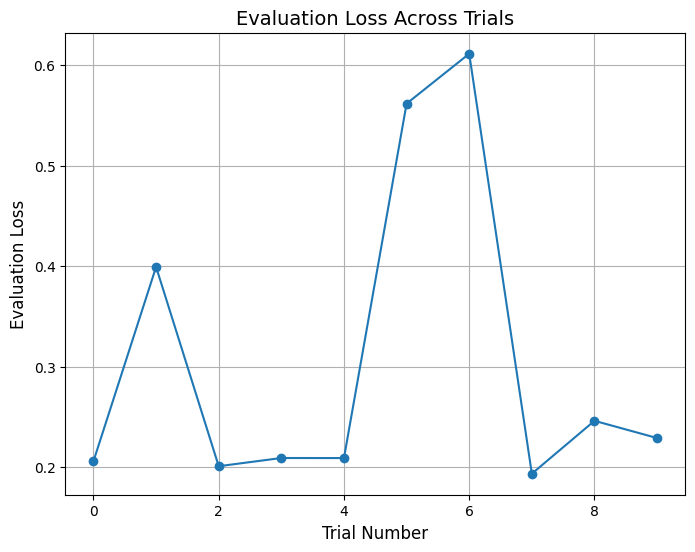

In [ ]:
import matplotlib.pyplot as plt

# Extract trial losses
trial_losses = [trial.value for trial in study.trials]

# Plot evaluation loss across trials
plt.figure(figsize=(8, 6))
plt.plot(range(len(trial_losses)), trial_losses, marker='o')
plt.title("Evaluation Loss Across Trials", fontsize=14)
plt.xlabel("Trial Number", fontsize=12)
plt.ylabel("Evaluation Loss", fontsize=12)
plt.grid(True)
plt.show()


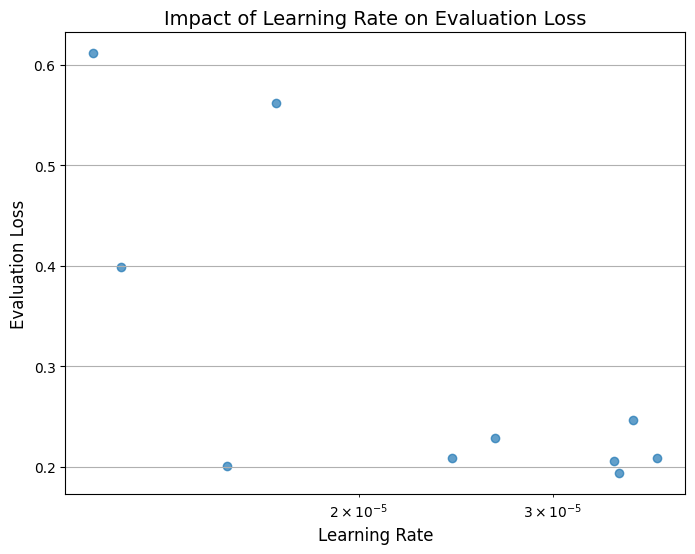

In [ ]:
import pandas as pd

# Create a DataFrame from trial data
df_trials = pd.DataFrame([{**trial.params, "eval_loss": trial.value} for trial in study.trials])

# Plot impact of learning rate on evaluation loss
plt.figure(figsize=(8, 6))
plt.scatter(df_trials["learning_rate"], df_trials["eval_loss"], alpha=0.7)
plt.xscale('log')  # Log scale for learning rate
plt.title("Impact of Learning Rate on Evaluation Loss", fontsize=14)
plt.xlabel("Learning Rate", fontsize=12)
plt.ylabel("Evaluation Loss", fontsize=12)
plt.grid(True)
plt.show()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,0.171400,0.193065


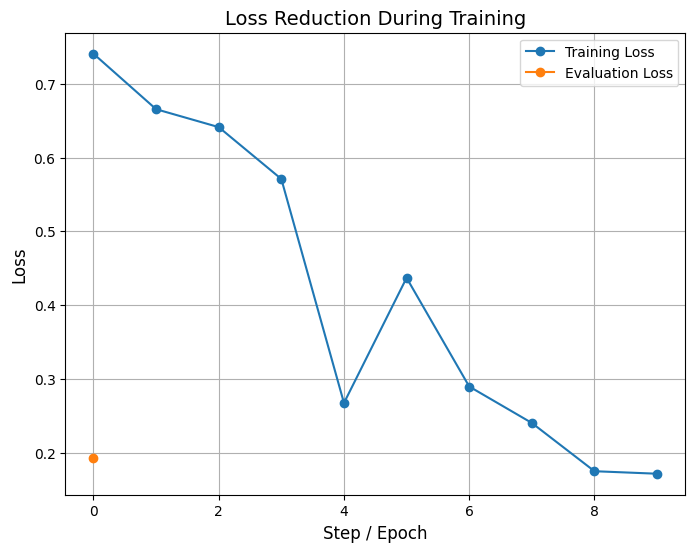

In [ ]:
from transformers import TrainerCallback

class LossTrackerCallback(TrainerCallback):
    """Custom callback to track training and evaluation loss."""
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.train_loss.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_loss.append(logs["eval_loss"])

# Instantiate and add the callback
loss_tracker = LossTrackerCallback()

# Train the model with the best configuration
trainer = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2),
    args=TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",
        learning_rate=best_config["learning_rate"],
        per_device_train_batch_size=best_config["batch_size"],
        num_train_epochs=best_config["epochs"],
        save_strategy="no",
        logging_dir=None,
        logging_steps=10,
    ),
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    callbacks=[loss_tracker],
)
trainer.train()

# Plot loss reduction
plt.figure(figsize=(8, 6))
plt.plot(loss_tracker.train_loss, label="Training Loss", marker='o')
plt.plot(loss_tracker.eval_loss, label="Evaluation Loss", marker='o')
plt.title("Loss Reduction During Training", fontsize=14)
plt.xlabel("Step / Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


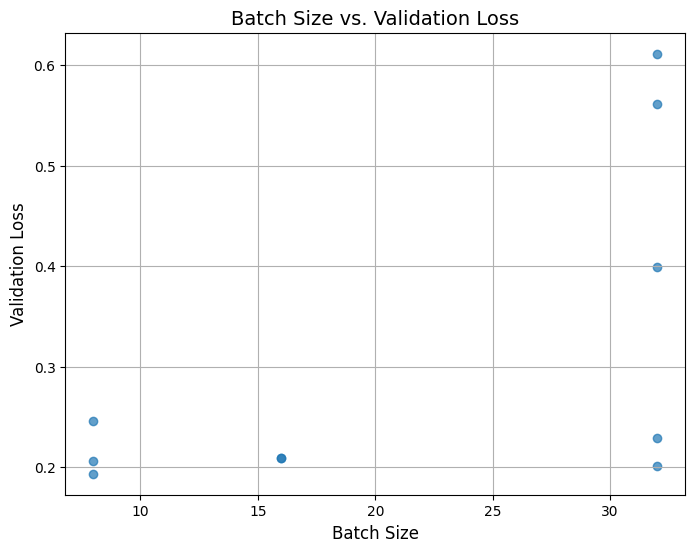

In [ ]:
import pandas as pd

# Trial data
data = {
    "trial": range(10),
    "batch_size": [8, 32, 32, 16, 16, 32, 32, 8, 8, 32],
    "validation_loss": trial_losses,
}

# Convert to DataFrame
df_trials = pd.DataFrame(data)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_trials["batch_size"], df_trials["validation_loss"], alpha=0.7)
plt.title("Batch Size vs. Validation Loss", fontsize=14)
plt.xlabel("Batch Size", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.grid(True)
plt.show()


**AdaLoRA run**

In [ ]:
# Install necessary libraries
!pip install transformers peft datasets kagglehub optuna torch

# Import required libraries
import kagglehub
import os
import bz2
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from peft import get_peft_model, AdaLoraConfig, TaskType  # Use AdaLoRA configuration
import optuna

# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print(f"Path to dataset: {dataset_path}")

# List dataset files
print("Files in the dataset:")
print(os.listdir(dataset_path))

# Paths to the train and test files
train_file = os.path.join(dataset_path, "train.ft.txt.bz2")
test_file = os.path.join(dataset_path, "test.ft.txt.bz2")

# Function to load a bz2 file into a pandas DataFrame
def load_bz2_file(file_path, num_lines=None):
    data = []
    with bz2.open(file_path, "rt", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if num_lines and i >= num_lines:
                break
            label, text = line.split(' ', 1)
            data.append({'label': label.strip(), 'text': text.strip()})
    return pd.DataFrame(data)

# Load a sample of the training data
train_data = load_bz2_file(train_file, num_lines=1000)
print("Sample of loaded training data:")
print(train_data.head())

# Preprocess labels to remove "__label__" prefix and convert to integers
train_data['label'] = train_data['label'].str.replace('__label__', '').astype(int) - 1

# Convert DataFrame to Hugging Face Dataset
dataset = Dataset.from_pandas(train_data)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Split dataset into training and validation sets
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.2)

# Define the function to train the model
def train_model(config, tokenized_datasets):
    """Trains and evaluates a model with AdaLoRA configuration."""

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    )

    # Configure AdaLoRA
    adalora_config = AdaLoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=config["lora_r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=config["lora_dropout"],
        target_modules=["query", "value"],
        init_r=config.get("init_r", 4),  # Initial rank
        beta1=config.get("beta1", 0.85),  # Beta1 for AdaLoRA optimization
        beta2=config.get("beta2", 0.85),  # Beta2 for AdaLoRA optimization
        tinit=config.get("tinit", 100),  # Iterations before rank adjustment
        tfinal=config.get("tfinal", 500),  # Iterations to stabilize
    )
    model = get_peft_model(model, adalora_config)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="epoch",
        learning_rate=config["learning_rate"],
        per_device_train_batch_size=config["batch_size"],
        num_train_epochs=config["epochs"],
        save_strategy="no",
        logging_dir=None,
        logging_steps=10,
        disable_tqdm=True,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"],
    )

    # Train the model
    trainer.train()

    # Return evaluation loss for optimization
    return trainer.evaluate()["eval_loss"]

# Define the objective function for Optuna optimization
def objective(trial):
    config = {
        "lora_r": trial.suggest_categorical("lora_r", [8, 16, 32]),
        "lora_alpha": trial.suggest_categorical("lora_alpha", [16, 32]),
        "lora_dropout": trial.suggest_categorical("lora_dropout", [0.1, 0.2]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "batch_size": trial.suggest_categorical("batch_size", [8, 16, 32]),
        "epochs": trial.suggest_int("epochs", 3, 5),
        "init_r": trial.suggest_int("init_r", 4, 8),
        "beta1": trial.suggest_float("beta1", 0.7, 0.9),
        "beta2": trial.suggest_float("beta2", 0.7, 0.9),
        "tinit": trial.suggest_int("tinit", 50, 200),
        "tfinal": trial.suggest_int("tfinal", 300, 1000),
    }
    return train_model(config, tokenized_datasets)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Display best hyperparameters
print("Best Hyperparameters Found:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# Optionally, display the best value (lowest loss)
print("\nBest evaluation loss achieved:", study.best_value)


Path to dataset: /root/.cache/kagglehub/datasets/bittlingmayer/amazonreviews/versions/7
Files in the dataset:
['train.ft.txt.bz2', 'test.ft.txt.bz2']
Sample of loaded training data:
        label                                               text
0  __label__2  Stuning even for the non-gamer: This sound tra...
1  __label__2  The best soundtrack ever to anything.: I'm rea...
2  __label__2  Amazing!: This soundtrack is my favorite music...
3  __label__2  Excellent Soundtrack: I truly like this soundt...
4  __label__2  Remember, Pull Your Jaw Off The Floor After He...


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[I 2024-12-09 04:22:05,399] A new study created in memory with name: no-name-bb99107c-869a-4921-8028-b23aee4d9a79
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.4776, 'grad_norm': 1.2263067960739136, 'learning_rate': 2.2442070816665696e-05, 'epoch': 0.4}
{'loss': 1.4633, 'grad_norm': 3.0587549209594727, 'learning_rate': 1.8989444537178665e-05, 'epoch': 0.8}
{'eval_loss': 1.4568051099777222, 'eval_runtime': 1.5864, 'eval_samples_per_second': 126.069, 'eval_steps_per_second': 15.759, 'epoch': 1.0}
{'loss': 1.46, 'grad_norm': 4.164021015167236, 'learning_rate': 1.5536818257691637e-05, 'epoch': 1.2}
{'loss': 1.4553, 'grad_norm': 0.9894309639930725, 'learning_rate': 1.2084191978204606e-05, 'epoch': 1.6}
{'loss': 1.4456, 'grad_norm': 1.8154619932174683, 'learning_rate': 8.631565698717575e-06, 'epoch': 2.0}
{'eval_loss': 1.4494891166687012, 'eval_runtime': 1.5981, 'eval_samples_per_second': 125.15, 'eval_steps_per_second': 15.644, 'epoch': 2.0}
{'loss': 1.444, 'grad_norm': 1.0840924978256226, 'learning_rate': 5.178939419230546e-06, 'epoch': 2.4}
{'loss': 1.4478, 'grad_norm': 0.9378947615623474, 'learning_rate': 1.7263131397435152e-06, 'epo

[I 2024-12-09 04:22:48,351] Trial 0 finished with value: 1.446458101272583 and parameters: {'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 2.5894697096152727e-05, 'batch_size': 32, 'epochs': 3, 'init_r': 5, 'beta1': 0.8179858668075654, 'beta2': 0.7943893670214391, 'tinit': 116, 'tfinal': 314}. Best is trial 0 with value: 1.446458101272583.


{'eval_loss': 1.446458101272583, 'eval_runtime': 1.5858, 'eval_samples_per_second': 126.119, 'eval_steps_per_second': 15.765, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.6313, 'grad_norm': 1.7639249563217163, 'learning_rate': 1.5047806400417846e-05, 'epoch': 0.1}
{'loss': 1.6115, 'grad_norm': 1.7194749116897583, 'learning_rate': 1.47407083106134e-05, 'epoch': 0.2}
{'loss': 1.5862, 'grad_norm': 1.6738297939300537, 'learning_rate': 1.4433610220808954e-05, 'epoch': 0.3}
{'loss': 1.6055, 'grad_norm': 3.0941431522369385, 'learning_rate': 1.412651213100451e-05, 'epoch': 0.4}
{'loss': 1.597, 'grad_norm': 9.366968154907227, 'learning_rate': 1.3819414041200064e-05, 'epoch': 0.5}
{'loss': 1.5525, 'grad_norm': 1.770740270614624, 'learning_rate': 1.3512315951395618e-05, 'epoch': 0.6}
{'loss': 1.5526, 'grad_norm': 3.16011118888855, 'learning_rate': 1.320521786159117e-05, 'epoch': 0.7}
{'loss': 1.5729, 'grad_norm': 5.491154670715332, 'learning_rate': 1.2898119771786724e-05, 'epoch': 0.8}
{'loss': 1.569, 'grad_norm': 4.8502678871154785, 'learning_rate': 1.2591021681982278e-05, 'epoch': 0.9}
{'loss': 1.5606, 'grad_norm': 1.8200576305389404, 'learning_rate':

[I 2024-12-09 04:24:08,090] Trial 1 finished with value: 1.4794094562530518 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 1.5354904490222292e-05, 'batch_size': 8, 'epochs': 5, 'init_r': 7, 'beta1': 0.7738947089993973, 'beta2': 0.7466013004650781, 'tinit': 58, 'tfinal': 836}. Best is trial 0 with value: 1.446458101272583.


{'eval_loss': 1.4794094562530518, 'eval_runtime': 1.5813, 'eval_samples_per_second': 126.482, 'eval_steps_per_second': 15.81, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.6709, 'grad_norm': 2.3395981788635254, 'learning_rate': 3.4302831885035946e-05, 'epoch': 0.2}
{'loss': 1.6842, 'grad_norm': 1.2894182205200195, 'learning_rate': 3.287354722315945e-05, 'epoch': 0.4}
{'loss': 1.6515, 'grad_norm': 3.569354295730591, 'learning_rate': 3.144426256128295e-05, 'epoch': 0.6}
{'loss': 1.6326, 'grad_norm': 1.9320012331008911, 'learning_rate': 3.001497789940645e-05, 'epoch': 0.8}
{'loss': 1.6217, 'grad_norm': 2.4154200553894043, 'learning_rate': 2.8585693237529957e-05, 'epoch': 1.0}
{'eval_loss': 1.6246963739395142, 'eval_runtime': 1.5853, 'eval_samples_per_second': 126.161, 'eval_steps_per_second': 15.77, 'epoch': 1.0}
{'loss': 1.6111, 'grad_norm': 4.524559497833252, 'learning_rate': 2.715640857565346e-05, 'epoch': 1.2}
{'loss': 1.5989, 'grad_norm': 1.1010411977767944, 'learning_rate': 2.5727123913776957e-05, 'epoch': 1.4}
{'loss': 1.6021, 'grad_norm': 1.3358851671218872, 'learning_rate': 2.4297839251900463e-05, 'epoch': 1.6}
{'loss': 1.5797, 'grad_nor

[I 2024-12-09 04:25:22,218] Trial 2 finished with value: 1.5044223070144653 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 3.5732116546912444e-05, 'batch_size': 16, 'epochs': 5, 'init_r': 8, 'beta1': 0.7708866822671606, 'beta2': 0.8892408966146451, 'tinit': 170, 'tfinal': 391}. Best is trial 0 with value: 1.446458101272583.


{'eval_loss': 1.5044223070144653, 'eval_runtime': 1.5817, 'eval_samples_per_second': 126.443, 'eval_steps_per_second': 15.805, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.3807, 'grad_norm': 3.951587438583374, 'learning_rate': 4.699284688675972e-05, 'epoch': 0.1}
{'loss': 1.3716, 'grad_norm': 3.979133367538452, 'learning_rate': 4.5372403890664564e-05, 'epoch': 0.2}
{'loss': 1.3601, 'grad_norm': 3.3103108406066895, 'learning_rate': 4.37519608945694e-05, 'epoch': 0.3}
{'loss': 1.3543, 'grad_norm': 1.7348058223724365, 'learning_rate': 4.2131517898474235e-05, 'epoch': 0.4}
{'loss': 1.3425, 'grad_norm': 8.001999855041504, 'learning_rate': 4.051107490237907e-05, 'epoch': 0.5}
{'loss': 1.3208, 'grad_norm': 3.1276662349700928, 'learning_rate': 3.889063190628391e-05, 'epoch': 0.6}
{'loss': 1.2882, 'grad_norm': 2.205848455429077, 'learning_rate': 3.727018891018875e-05, 'epoch': 0.7}
{'loss': 1.2911, 'grad_norm': 4.494317531585693, 'learning_rate': 3.564974591409358e-05, 'epoch': 0.8}
{'loss': 1.2783, 'grad_norm': 4.7895073890686035, 'learning_rate': 3.402930291799842e-05, 'epoch': 0.9}
{'loss': 1.2791, 'grad_norm': 2.4088196754455566, 'learning_rate': 3

[I 2024-12-09 04:26:11,045] Trial 3 finished with value: 1.1636993885040283 and parameters: {'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 4.8613289882854886e-05, 'batch_size': 8, 'epochs': 3, 'init_r': 4, 'beta1': 0.8635330870099205, 'beta2': 0.7257353613726647, 'tinit': 164, 'tfinal': 684}. Best is trial 3 with value: 1.1636993885040283.


{'eval_loss': 1.1636993885040283, 'eval_runtime': 1.5844, 'eval_samples_per_second': 126.228, 'eval_steps_per_second': 15.779, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/adalora/config.py:74: UserWarning: Note that `r` is not used in AdaLora and will be ignored.If you intended to set the initial rank, use `init_r` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.5617, 'grad_norm': 1.9068058729171753, 'learning_rate': 3.090978363435625e-05, 'epoch': 0.2}
{'loss': 1.5458, 'grad_norm': 2.199669361114502, 'learning_rate': 2.9282952916758554e-05, 'epoch': 0.4}
{'loss': 1.5217, 'grad_norm': 1.9806355237960815, 'learning_rate': 2.7656122199160856e-05, 'epoch': 0.6}
{'loss': 1.5028, 'grad_norm': 1.4408001899719238, 'learning_rate': 2.602929148156316e-05, 'epoch': 0.8}
{'loss': 1.503, 'grad_norm': 3.0576746463775635, 'learning_rate': 2.4402460763965462e-05, 'epoch': 1.0}
{'eval_loss': 1.5029690265655518, 'eval_runtime': 1.5843, 'eval_samples_per_second': 126.241, 'eval_steps_per_second': 15.78, 'epoch': 1.0}
{'loss': 1.4791, 'grad_norm': 3.9758033752441406, 'learning_rate': 2.277563004636776e-05, 'epoch': 1.2}
{'loss': 1.4789, 'grad_norm': 1.1307950019836426, 'learning_rate': 2.1148799328770066e-05, 'epoch': 1.4}
{'loss': 1.4834, 'grad_norm': 1.3259897232055664, 'learning_rate': 1.9521968611172367e-05, 'epoch': 1.6}
{'loss': 1.4715, 'grad_no

[I 2024-12-09 04:27:10,764] Trial 4 finished with value: 1.4353835582733154 and parameters: {'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.1, 'learning_rate': 3.253661435195395e-05, 'batch_size': 16, 'epochs': 4, 'init_r': 6, 'beta1': 0.7472653606955253, 'beta2': 0.7065706926123486, 'tinit': 93, 'tfinal': 328}. Best is trial 3 with value: 1.1636993885040283.


{'eval_loss': 1.4353835582733154, 'eval_runtime': 1.5875, 'eval_samples_per_second': 125.981, 'eval_steps_per_second': 15.748, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/adalora/config.py:74: UserWarning: Note that `r` is not used in AdaLora and will be ignored.If you intended to set the initial rank, use `init_r` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.5241, 'grad_norm': 2.2299132347106934, 'learning_rate': 1.3939424692400494e-05, 'epoch': 0.2}
{'loss': 1.5606, 'grad_norm': 1.8738735914230347, 'learning_rate': 1.3358615330217142e-05, 'epoch': 0.4}
{'loss': 1.5496, 'grad_norm': 4.437680721282959, 'learning_rate': 1.2777805968033786e-05, 'epoch': 0.6}
{'loss': 1.5379, 'grad_norm': 2.8690781593322754, 'learning_rate': 1.2196996605850432e-05, 'epoch': 0.8}
{'loss': 1.5374, 'grad_norm': 1.422552466392517, 'learning_rate': 1.161618724366708e-05, 'epoch': 1.0}
{'eval_loss': 1.5182303190231323, 'eval_runtime': 1.5846, 'eval_samples_per_second': 126.218, 'eval_steps_per_second': 15.777, 'epoch': 1.0}
{'loss': 1.5235, 'grad_norm': 5.878890037536621, 'learning_rate': 1.1035377881483725e-05, 'epoch': 1.2}
{'loss': 1.5286, 'grad_norm': 2.0294840335845947, 'learning_rate': 1.0454568519300371e-05, 'epoch': 1.4}
{'loss': 1.5266, 'grad_norm': 1.3642542362213135, 'learning_rate': 9.873759157117017e-06, 'epoch': 1.6}
{'loss': 1.5146, 'grad_n

[I 2024-12-09 04:28:25,066] Trial 5 finished with value: 1.479050874710083 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 1.4520234054583848e-05, 'batch_size': 16, 'epochs': 5, 'init_r': 6, 'beta1': 0.8759851463385443, 'beta2': 0.7350733008322855, 'tinit': 134, 'tfinal': 927}. Best is trial 3 with value: 1.1636993885040283.


{'eval_loss': 1.479050874710083, 'eval_runtime': 1.5843, 'eval_samples_per_second': 126.237, 'eval_steps_per_second': 15.78, 'epoch': 5.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.5367, 'grad_norm': 3.942260503768921, 'learning_rate': 4.803693006176675e-05, 'epoch': 0.1}
{'loss': 1.5247, 'grad_norm': 3.958035945892334, 'learning_rate': 4.6805213906336833e-05, 'epoch': 0.2}
{'loss': 1.5099, 'grad_norm': 3.281635046005249, 'learning_rate': 4.557349775090692e-05, 'epoch': 0.3}
{'loss': 1.5009, 'grad_norm': 1.7461621761322021, 'learning_rate': 4.4341781595477e-05, 'epoch': 0.4}
{'loss': 1.4863, 'grad_norm': 8.031006813049316, 'learning_rate': 4.3110065440047084e-05, 'epoch': 0.5}
{'loss': 1.4602, 'grad_norm': 3.082951545715332, 'learning_rate': 4.187834928461717e-05, 'epoch': 0.6}
{'loss': 1.4237, 'grad_norm': 2.2612051963806152, 'learning_rate': 4.064663312918725e-05, 'epoch': 0.7}
{'loss': 1.424, 'grad_norm': 4.589003562927246, 'learning_rate': 3.9414916973757335e-05, 'epoch': 0.8}
{'loss': 1.4083, 'grad_norm': 4.854175090789795, 'learning_rate': 3.818320081832742e-05, 'epoch': 0.9}
{'loss': 1.4046, 'grad_norm': 2.3507702350616455, 'learning_rate': 3.69

[I 2024-12-09 04:29:29,459] Trial 6 finished with value: 1.1409393548965454 and parameters: {'lora_r': 8, 'lora_alpha': 32, 'lora_dropout': 0.2, 'learning_rate': 4.9268646217196666e-05, 'batch_size': 8, 'epochs': 4, 'init_r': 6, 'beta1': 0.7103408273240032, 'beta2': 0.7462692263345836, 'tinit': 168, 'tfinal': 609}. Best is trial 6 with value: 1.1409393548965454.


{'eval_loss': 1.1409393548965454, 'eval_runtime': 1.5858, 'eval_samples_per_second': 126.117, 'eval_steps_per_second': 15.765, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/adalora/config.py:74: UserWarning: Note that `r` is not used in AdaLora and will be ignored.If you intended to set the initial rank, use `init_r` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.4512, 'grad_norm': 2.2979865074157715, 'learning_rate': 9.517018306621981e-06, 'epoch': 0.2}
{'loss': 1.4915, 'grad_norm': 2.0321896076202393, 'learning_rate': 9.016122606273456e-06, 'epoch': 0.4}
{'loss': 1.4845, 'grad_norm': 4.711008548736572, 'learning_rate': 8.51522690592493e-06, 'epoch': 0.6}
{'loss': 1.4782, 'grad_norm': 3.2051477432250977, 'learning_rate': 8.014331205576406e-06, 'epoch': 0.8}
{'loss': 1.4772, 'grad_norm': 1.194888949394226, 'learning_rate': 7.513435505227879e-06, 'epoch': 1.0}
{'eval_loss': 1.455305814743042, 'eval_runtime': 1.5846, 'eval_samples_per_second': 126.215, 'eval_steps_per_second': 15.777, 'epoch': 1.0}
{'loss': 1.4653, 'grad_norm': 6.342822551727295, 'learning_rate': 7.012539804879354e-06, 'epoch': 1.2}
{'loss': 1.4717, 'grad_norm': 2.545736789703369, 'learning_rate': 6.511644104530829e-06, 'epoch': 1.4}
{'loss': 1.4667, 'grad_norm': 1.6258760690689087, 'learning_rate': 6.010748404182303e-06, 'epoch': 1.6}
{'loss': 1.4651, 'grad_norm': 2.5

[I 2024-12-09 04:30:29,227] Trial 7 finished with value: 1.4331663846969604 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 1.0017914006970506e-05, 'batch_size': 16, 'epochs': 4, 'init_r': 5, 'beta1': 0.8209693790989856, 'beta2': 0.8754468980091565, 'tinit': 57, 'tfinal': 485}. Best is trial 6 with value: 1.1409393548965454.


{'eval_loss': 1.4331663846969604, 'eval_runtime': 1.5823, 'eval_samples_per_second': 126.402, 'eval_steps_per_second': 15.8, 'epoch': 4.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/adalora/config.py:74: UserWarning: Note that `r` is not used in AdaLora and will be ignored.If you intended to set the initial rank, use `init_r` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.5511, 'grad_norm': 1.3734428882598877, 'learning_rate': 2.1158659911791153e-05, 'epoch': 0.4}
{'loss': 1.5514, 'grad_norm': 4.314159393310547, 'learning_rate': 1.790348146382328e-05, 'epoch': 0.8}
{'eval_loss': 1.5211442708969116, 'eval_runtime': 1.5782, 'eval_samples_per_second': 126.729, 'eval_steps_per_second': 15.841, 'epoch': 1.0}
{'loss': 1.5399, 'grad_norm': 4.800750255584717, 'learning_rate': 1.4648303015855411e-05, 'epoch': 1.2}
{'loss': 1.5193, 'grad_norm': 1.0708624124526978, 'learning_rate': 1.1393124567887542e-05, 'epoch': 1.6}
{'loss': 1.5121, 'grad_norm': 1.9528310298919678, 'learning_rate': 8.137946119919673e-06, 'epoch': 2.0}
{'eval_loss': 1.5094902515411377, 'eval_runtime': 1.5827, 'eval_samples_per_second': 126.365, 'eval_steps_per_second': 15.796, 'epoch': 2.0}
{'loss': 1.5116, 'grad_norm': 0.8097913861274719, 'learning_rate': 4.882767671951804e-06, 'epoch': 2.4}
{'loss': 1.5047, 'grad_norm': 0.9906168580055237, 'learning_rate': 1.6275892239839347e-06, 'e

[I 2024-12-09 04:31:12,089] Trial 8 finished with value: 1.506037950515747 and parameters: {'lora_r': 32, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 2.441383835975902e-05, 'batch_size': 32, 'epochs': 3, 'init_r': 6, 'beta1': 0.7368212732738754, 'beta2': 0.8338252083707695, 'tinit': 186, 'tfinal': 630}. Best is trial 6 with value: 1.1409393548965454.


{'eval_loss': 1.506037950515747, 'eval_runtime': 1.5851, 'eval_samples_per_second': 126.174, 'eval_steps_per_second': 15.772, 'epoch': 3.0}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/peft/tuners/adalora/config.py:74: UserWarning: Note that `r` is not used in AdaLora and will be ignored.If you intended to set the initial rank, use `init_r` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'loss': 1.4823, 'grad_norm': 2.715989112854004, 'learning_rate': 2.8845450783622675e-05, 'epoch': 0.4}
{'loss': 1.4477, 'grad_norm': 2.0878803730010986, 'learning_rate': 2.5640400696553488e-05, 'epoch': 0.8}
{'eval_loss': 1.4509533643722534, 'eval_runtime': 1.5796, 'eval_samples_per_second': 126.613, 'eval_steps_per_second': 15.827, 'epoch': 1.0}
{'loss': 1.4432, 'grad_norm': 3.1277763843536377, 'learning_rate': 2.24353506094843e-05, 'epoch': 1.2}
{'loss': 1.438, 'grad_norm': 0.8437995910644531, 'learning_rate': 1.9230300522415113e-05, 'epoch': 1.6}
{'loss': 1.4329, 'grad_norm': 1.1233497858047485, 'learning_rate': 1.602525043534593e-05, 'epoch': 2.0}
{'eval_loss': 1.4355887174606323, 'eval_runtime': 1.5818, 'eval_samples_per_second': 126.44, 'eval_steps_per_second': 15.805, 'epoch': 2.0}
{'loss': 1.4275, 'grad_norm': 1.4009759426116943, 'learning_rate': 1.2820200348276744e-05, 'epoch': 2.4}
{'loss': 1.429, 'grad_norm': 1.5196526050567627, 'learning_rate': 9.615150261207557e-06, 'epoc

[I 2024-12-09 04:32:08,472] Trial 9 finished with value: 1.42130446434021 and parameters: {'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.2, 'learning_rate': 3.205050087069186e-05, 'batch_size': 32, 'epochs': 4, 'init_r': 5, 'beta1': 0.8705323810894048, 'beta2': 0.7050095471531064, 'tinit': 146, 'tfinal': 936}. Best is trial 6 with value: 1.1409393548965454.


{'eval_loss': 1.42130446434021, 'eval_runtime': 1.5885, 'eval_samples_per_second': 125.908, 'eval_steps_per_second': 15.739, 'epoch': 4.0}
Best Hyperparameters Found:
lora_r: 8
lora_alpha: 32
lora_dropout: 0.2
learning_rate: 4.9268646217196666e-05
batch_size: 8
epochs: 4
init_r: 6
beta1: 0.7103408273240032
beta2: 0.7462692263345836
tinit: 168
tfinal: 609

Best evaluation loss achieved: 1.1409393548965454


In [ ]:
import pandas as pd

# Data
data = {
    "Trial": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Eval Loss": [1.4465, 1.4794, 1.5044, 1.1637, 1.4354, 1.4791, 1.1409, 1.4332, 1.5060, 1.4213],
    "lora_r": [8, 8, 8, 8, 16, 16, 8, 16, 32, 16],
    "lora_alpha": [16, 32, 32, 16, 32, 16, 32, 16, 16, 16],
    "lora_dropout": [0.2, 0.2, 0.1, 0.2, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2],
    "Learning Rate": [
        2.5895e-05, 1.5355e-05, 3.5732e-05, 4.8613e-05, 3.2537e-05,
        1.4520e-05, 4.9269e-05, 1.0018e-05, 2.4414e-05, 3.2051e-05
    ],
    "Batch Size": [32, 8, 16, 8, 16, 16, 8, 16, 32, 32],
    "Epochs": [3, 5, 5, 3, 4, 5, 4, 4, 3, 4],
    "init_r": [5, 7, 8, 4, 6, 6, 6, 5, 6, 5],
    "beta1": [0.8180, 0.7739, 0.7709, 0.8635, 0.7473, 0.8760, 0.7103, 0.8210, 0.7368, 0.8705],
    "beta2": [0.7944, 0.7466, 0.8892, 0.7257, 0.7066, 0.7351, 0.7463, 0.8754, 0.8338, 0.7050],
    "tinit": [116, 58, 170, 164, 93, 134, 168, 57, 186, 146],
    "tfinal": [314, 836, 391, 684, 328, 927, 609, 485, 630, 936]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
df


,Trial,Eval Loss,lora_r,lora_alpha,lora_dropout,Learning Rate,Batch Size,Epochs,init_r,beta1,beta2,tinit,tfinal
0,0,1.4465,8,16,0.2,0.000026,32,3,5,0.8180,0.7944,116,314
1,1,1.4794,8,32,0.2,0.000015,8,5,7,0.7739,0.7466,58,836
2,2,1.5044,8,32,0.1,0.000036,16,5,8,0.7709,0.8892,170,391
3,3,1.1637,8,16,0.2,0.000049,8,3,4,0.8635,0.7257,164,684
4,4,1.4354,16,32,0.1,0.000033,16,4,6,0.7473,0.7066,93,328
5,5,1.4791,16,16,0.2,0.000015,16,5,6,0.8760,0.7351,134,927
6,6,1.1409,8,32,0.2,0.000049,8,4,6,0.7103,0.7463,168,609
7,7,1.4332,16,16,0.2,0.000010,16,4,5,0.8210,0.8754,57,485
8,8,1.5060,32,16,0.2,0.000024,32,3,6,0.7368,0.8338,186,630
9,9,1.4213,16,16,0.2,0.000032,32,4,5,0.8705,0.7050,146,936


In [ ]:
!pip install -U bitsandbytes